# Read and parse data 

In [1]:
import add_to_syspath
from audiomnist.io.read_dataset import load_audionet_dataset
from audiomnist.train.audionet import split, make_tuple
import tensorflow as tf
from IPython.display import Audio

In [2]:
tf.enable_eager_execution()
dataset = load_audionet_dataset("../tf_data/audionet.tfrecords")

for e in dataset.take(1200): pass

Audio(e['data'].numpy().flatten(),rate = 8000)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
import matplotlib.pyplot as plt
plt.plot(e['data'].numpy())
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
e['digit']

<tf.Tensor: id=4829, shape=(), dtype=int64, numpy=3>

# Standardization

In [5]:
from tqdm import tqdm
maxi = 0
pbar = tqdm(total = 30000)
for e in dataset :
    pbar.update(1)
    l = e['data'].numpy().flatten()
    maxi = max(max(max(l),abs(min(l))),maxi)

100%|█████████▉| 29985/30000 [01:16<00:00, 399.95it/s]

In [6]:
maxi

58.66518

# Auto-encoder model

In [3]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
splits={"digit":{   "train":[   set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53, 36, 57,  9, 24, 37,  2, \
                                          8, 17, 29, 39, 48, 54, 43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55]),

                                    set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54, 43, 58, 14, 25, 38,  3, \
                                         10, 20, 30, 40, 49, 55, 12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50]),

                                    set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55, 12, 47, 59, 15, 27, 41, \
                                          4, 11, 21, 31, 44, 50, 26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),

                                    set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50, 26, 52, 60, 18, 32, 42, \
                                          5, 13, 22, 33, 45, 51, 28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),

                                    set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51, 28, 56,  7, 19, 35,  1, \
                                          6, 16, 23, 34, 46, 53, 36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54])],

                        "validate":[set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50]),
                                    set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                                    set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                                    set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54]),
                                    set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55])],

                        "test":[    set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                                    set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                                    set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54]),
                                    set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55]),
                                    set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50])]},

            "gender":{  "train":[   set([36, 47, 56, 26, 12, 57, 2, 44, 50, 25, 37, 45]),
                                    set([26, 12, 57, 43, 28, 52, 25, 37, 45, 48, 53, 41]),
                                    set([43, 28, 52, 58, 59, 60, 48, 53, 41, 7, 23, 38]),
                                    set([58, 59, 60, 36, 47, 56, 7, 23, 38, 2, 44, 50])],

                        "validate":[set([43, 28, 52, 48, 53, 41]),
                                    set([58, 59, 60, 7, 23, 38]),
                                    set([36, 47, 56, 2, 44, 50]),
                                    set([26, 12, 57, 25, 37, 45])],

                        "test":[    set([58, 59, 60, 7, 23, 38]),
                                    set([36, 47, 56, 2, 44, 50]),
                                    set([26, 12, 57, 25, 37, 45]),
                                    set([43, 28, 52, 48, 53, 41])]}}

In [5]:
def make_tuple(record):
    return (tf.reshape(record['data'],(8000,1)),tf.reshape(record['data'],(8000,1)))


batch_size = 100

train_dataset = dataset.filter(split('digit', 'train')) \
    .map(make_tuple) \
    .shuffle(18000, seed=42) \
    .batch(batch_size) \
    .repeat()

train_nb_samples = len(splits['digit']['train'][0])*500


test_dataset = dataset.filter(split('digit', 'test')) \
    .map(make_tuple) \
    .shuffle(10000, seed=42) \
    .batch(batch_size)

test_nb_samples = len(splits['digit']['test'][0])*500

In [9]:
input_img= Input(shape=(8000,1))

encoded = Conv1D(filters = 32,kernel_size = 3,activation = 'relu',padding ='same')(input_img)
encoded = MaxPooling1D(pool_size =  2)(encoded)
encoded = Conv1D(filters = 64,kernel_size = 3,activation = 'relu',padding ='same')(encoded)
encoded = MaxPooling1D(pool_size =  2)(encoded)
encoded = Conv1D(filters = 128,kernel_size = 3,activation = 'relu',padding ='same')(encoded)
encoded = MaxPooling1D(pool_size =  2)(encoded)
encoded = Conv1D(filters = 256,kernel_size = 3,activation = 'relu',padding ='same')(encoded)

decoded = Conv1D(filters = 256,kernel_size = 3,activation = 'relu',padding ='same')(encoded)
decoded = UpSampling1D(size = 2)(decoded)
decoded = Conv1D(filters = 128,kernel_size = 3,activation = 'relu',padding ='same')(decoded)
decoded = UpSampling1D(size = 2)(decoded)
decoded = Conv1D(filters = 64,kernel_size = 3,activation = 'relu',padding ='same')(decoded)
decoded = UpSampling1D(size = 2)(decoded)
decoded = Conv1D(filters = 1,kernel_size = 3,activation = 'linear',padding ='same')(decoded)

#encoded = Dense(units=8000, activation='linear')(input_img)
#decoded = Dense(units=8000, activation='linear')(encoded)

autoencoder=Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [10]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 8000, 32)          128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4000, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 4000, 64)          6208      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2000, 64)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 2000, 128)         24704     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1000, 128)         0         
__________

In [11]:
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
autoencoder.compile(optimizer=adam, loss='mse', metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


In [12]:
for e in train_dataset.take(1):pass
e[0][0,:]

<tf.Tensor: id=18683, shape=(8000, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [13]:
import math
autoencoder.fit(train_dataset,
                epochs=50,
                steps_per_epoch = math.ceil(train_nb_samples/batch_size),
                batch_size=100,
                shuffle=True,
                validation_data=test_dataset,
                validation_steps=math.ceil(test_nb_samples/batch_size))

Epoch 1/50
Instructions for updating:
Use tf.cast instead.
180/180 [==============================] - 534s 3s/step - loss: 0.0995 - acc: 0.3572 - val_loss: 0.0396 - val_acc: 0.3362
Epoch 2/50
 92/180 [==============>...............] - ETA: 3:00 - loss: 0.0406 - acc: 0.3578

KeyboardInterrupt: 

# Validation

In [108]:
import matplotlib.pyplot as plt 

In [109]:
validate_dataset = dataset.filter(split('digit', 'validate')) \
    .map(make_tuple) \
    .shuffle(10000, seed=42) \
    .batch(batch_size)

validate_nb_samples = len(splits['digit']['validate'][0])*500


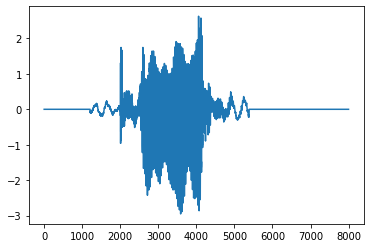

In [110]:
#for e in validate_dataset.take(120): pass


plt.plot(np.array(e[0][0,:]).flatten())
plt.show()

Audio(np.array(e[0][0,:]).flatten(),rate = 8000)

In [132]:
import os
import gc
import glob

def get_epoch_checkpoint(checkpoint_path, epoch):
    epoch_checkpoint = glob.glob(os.path.join(checkpoint_path, f"model3.{epoch}-*.data*"))
    print(epoch_checkpoint)
    assert len(epoch_checkpoint) == 1
    epoch_checkpoint = epoch_checkpoint[0].split(".data")[0]
    return epoch_checkpoint

In [133]:
checkpoint_path = "../models/autoencoder3"
epoch_checkpoint = get_epoch_checkpoint(checkpoint_path, 59)
autoencoder.load_weights(epoch_checkpoint)
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
#autoencoder.compile(optimizer=adam, loss='mse', metrics=['accuracy'])

['../models/autoencoder3/model3.59-0.00.data-00000-of-00001']


In [134]:
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              16386048  
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_13 (Dense)             (None, 8000)              16392000  
Total para

In [147]:
for e in test_dataset:pass

In [159]:
import math
ini = tf.reshape(e[0][1],[1,8000])
after = autoencoder.predict(ini, steps = 1)

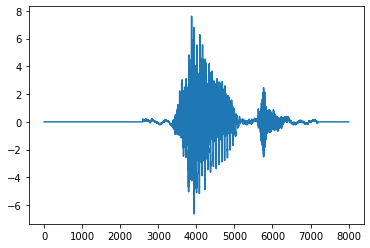

In [160]:
plt.plot(np.array(ini).flatten())
plt.show()

Audio(np.array(ini).flatten(),rate = 8000)

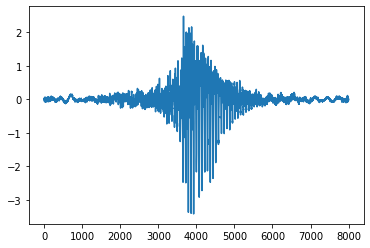

In [161]:
plt.plot(np.array(after).flatten())
plt.show()

Audio(np.array(after).flatten(),rate = 8000)